<a href="https://colab.research.google.com/github/cassandra-t-ye/6.c27-Final-Project/blob/main/ComputationalPSFandNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
import cv2 as cv

Load image z-stacks

In [3]:
# Show image info
def img_info(im):
    print(f'type: {type(im)}\ndtype: {im.dtype}\nsmallest pixel value: {np.min(im)}\nlargest pixel value: {np.max(im)}')

# load an image
img = torch.from_numpy(cv.resize(shepp_logan_phantom(),(256,256)))
img_dim = torch.Tensor.size(img)
# print the info
# img_info(img)

Convolve with known Gaussian PSF

In [4]:
def generate_gaussian_psf(size, omega):
    """
    Generate a Gaussian PSF.

    Parameters:
        size (int): The size of the PSF grid. The grid will be of dimensions [size x size].
        omega (float): The standard deviation of the Gaussian.

    Returns:
        torch.Tensor: A [size x size] tensor representing the Gaussian PSF.
    """
    # Create coordinate grid
    x = torch.linspace(-size // 2 + 1, size // 2, steps=size)
    y = torch.linspace(-size // 2 + 1, size // 2, steps=size)
    x, y = torch.meshgrid(x, y, indexing='xy')

    # Calculate Gaussian
    gaussian = torch.exp(-(x**2+y**2)/(2*omega**2))

    # Normalize so that the sum of all elements is 1
    gaussian = gaussian / torch.sum(gaussian)

    return gaussian

In [5]:
def fft_convolve_image(f, H):
    """
    Perform convolution of an image and a PSF using FFT.

    Parameters:
    - f (torch.Tensor): 2D tensor representing the object.
    - H (torch.Tensor): 2D tensor representing the PSF.

    Returns:
    - torch.Tensor: 2D tensor representing the convolved image.
    """
    # Perform FFT of the object
    F = torch.fft.fftshift(torch.fft.fft2(f))

    # Perform FFT of the PSF (pupil function)
    H = torch.fft.fftshift(torch.fft.fft2(H))

    # Convolve in frequency domain
    G = torch.mul(F,H)

    # Perform inverse FFT
    g = torch.fft.fftshift(torch.fft.ifft2(G))

    return torch.abs(g)

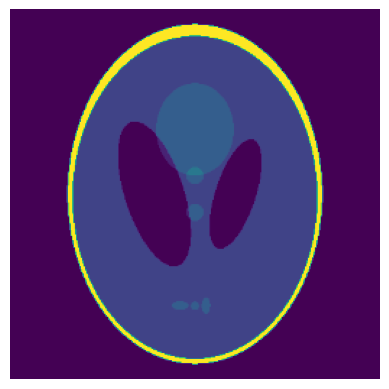

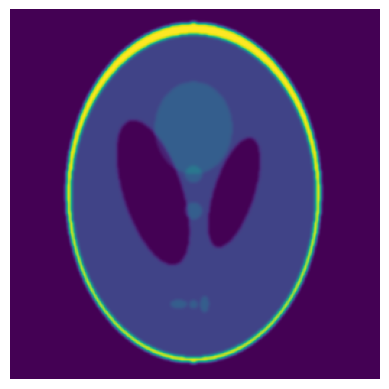

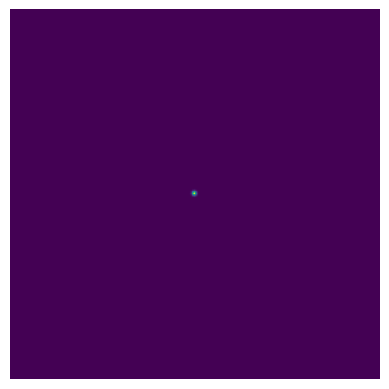

In [6]:
psf = generate_gaussian_psf(256, 1)
blur_img = fft_convolve_image(img,psf)
plt.imshow(img)
plt.axis('off')
plt.show()
plt.imshow(blur_img)
plt.axis('off')
plt.show()
plt.imshow(psf)
plt.axis('off')
plt.show()

Add Poisson & Gaussian noise

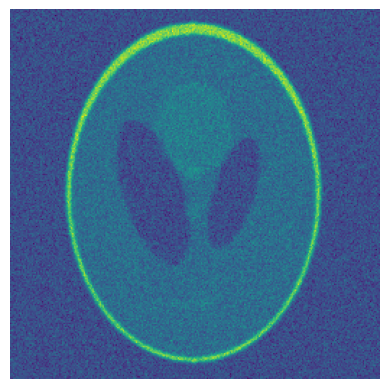

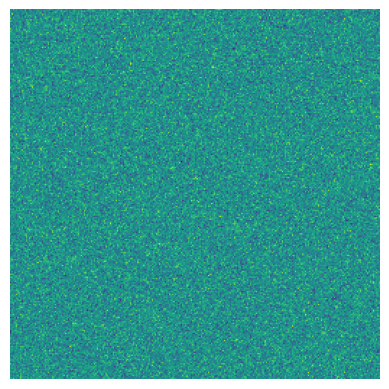

In [7]:
blur_noisy_img = blur_img + 0.1*torch.randn(img_dim)

plt.imshow(blur_noisy_img)
plt.axis('off')
plt.show()
plt.imshow(0.01*torch.randn(img_dim))
plt.axis('off')
plt.show()

Deconvolve blurred & noisy image with Tikhonov regularization

In [8]:
def tikhonov(f, H, lam=0.01):
    """
    Perform Tikhonov regularization.

    Parameters:
    - f (torch.Tensor): 2D tensor representing the object.
    - H (torch.Tensor): 2D tensor representing the PSF.

    Returns:
    - torch.Tensor: 2D tensor representing the deconvolved image.
    """
    # Perform FFT of the object
    F = (torch.fft.fft2(f))

    # Perform FFT of the PSF (pupil function)
    H = (torch.fft.fft2(H))

    # Implement Tikhonov regularization
    Fhat = (torch.conj(H)*F)/ (torch.square(torch.abs(H))+lam)
    fhat = torch.real((torch.fft.ifftshift(torch.fft.ifft2(Fhat), dim=(-2, -1))))

    return fhat

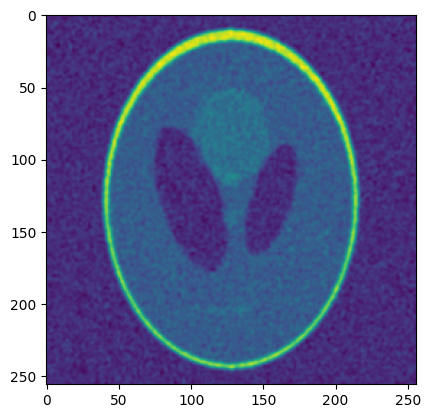

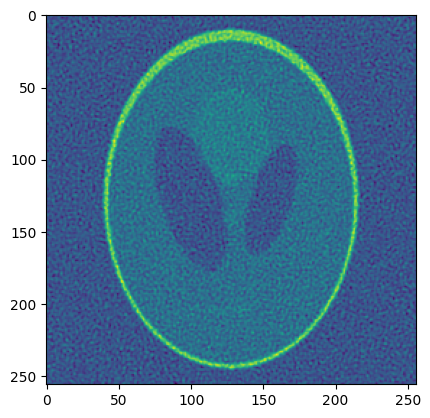

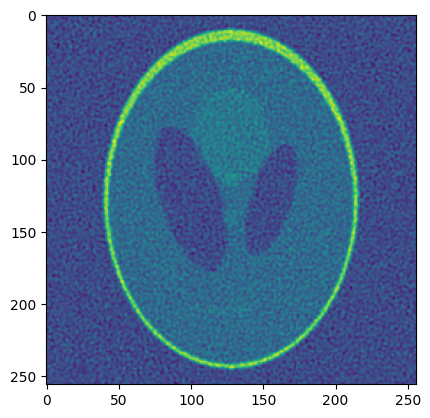

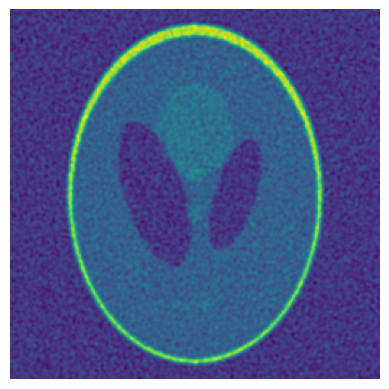

In [13]:
tik_img = tikhonov(blur_noisy_img,psf,lam=2)
plt.imshow(tik_img)
plt.show()

tik_img = tikhonov(blur_noisy_img,psf,lam=0.05)
plt.imshow(tik_img)
plt.show()

tik_img = tikhonov(blur_noisy_img,psf,lam=0.1)
plt.imshow(tik_img)
plt.show()

tik_img = tikhonov(blur_noisy_img,psf,lam=0.5)
plt.imshow(tik_img)
plt.axis('off')
plt.show()

In [17]:
loss = torch.nn.MSELoss()
mse_tik = loss(tik_img,img)
print(mse_tik.item())

0.010584149323834058


BM3D

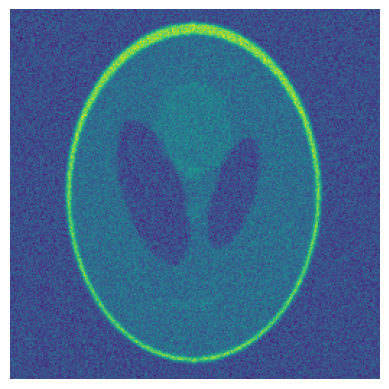

0.017724805272894113


In [28]:
import bm3d
bm3d_img = bm3d.bm3d(blur_noisy_img,sigma_psd=0.01, stage_arg=bm3d.BM3DStages.ALL_STAGES)

plt.imshow(bm3d_img)
plt.axis('off')
plt.show()

loss = torch.nn.MSELoss()
mse_bm3d = loss(torch.tensor(bm3d_img),img)
print(mse_bm3d.item())

Import experimental data

In [40]:
img20 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0020.png'),cv.COLOR_BGR2GRAY),(256,256)))
img21 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0021.png'),cv.COLOR_BGR2GRAY),(256,256)))
img22 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0022.png'),cv.COLOR_BGR2GRAY),(256,256)))
img23 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0023.png'),cv.COLOR_BGR2GRAY),(256,256)))
img24 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0024.png'),cv.COLOR_BGR2GRAY),(256,256)))
img25 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0025.png'),cv.COLOR_BGR2GRAY),(256,256)))
img26 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0026.png'),cv.COLOR_BGR2GRAY),(256,256)))
img27 = torch.tensor(cv.resize(cv.cvtColor(cv.imread('/content/drive/MyDrive/Colab Notebooks/HEK_nonFPS_MNP_cell_body0027.png'),cv.COLOR_BGR2GRAY),(256,256)))

img20 = fft_convolve_image(img20,psf) + 0.1*torch.randn((256,256))
img21 = fft_convolve_image(img21,psf) + 0.1*torch.randn((256,256))
img22 = fft_convolve_image(img22,psf) + 0.1*torch.randn((256,256))
img23 = fft_convolve_image(img23,psf) + 0.1*torch.randn((256,256))
img24 = fft_convolve_image(img24,psf) + 0.1*torch.randn((256,256))
img25 = fft_convolve_image(img25,psf) + 0.1*torch.randn((256,256))
img26 = fft_convolve_image(img26,psf) + 0.1*torch.randn((256,256))
img27 = fft_convolve_image(img27,psf) + 0.1*torch.randn((256,256))

zstack = torch.stack((img20,img21,img22,img23,img24,img25,img26,img27))

Noisy image

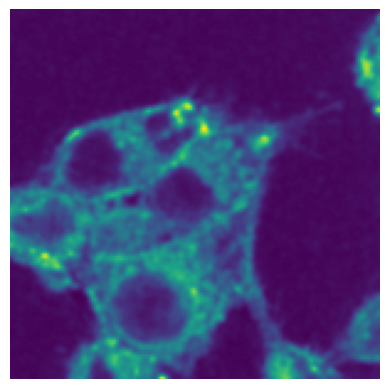

TypeError: ignored

In [36]:
plt.imshow(img26[50:200,50:200])
plt.axis('off')
plt.show()

BM4D

In [41]:
import bm4d
bm4d_stack = bm4d.bm4d(zstack,sigma_psd=0.01,stage_arg=bm4d.BM4DStages.ALL_STAGES)

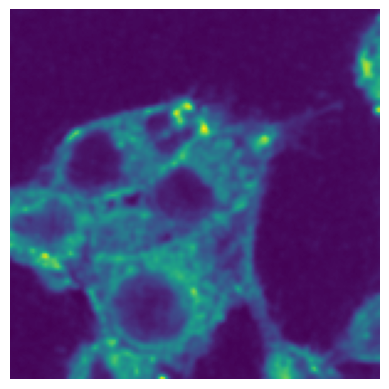

In [42]:
bm4d_img2 = bm4d_stack[6,:,:]
plt.imshow(bm4d_img2[50:200,50:200])
plt.axis('off')
plt.show()

Tikhonov

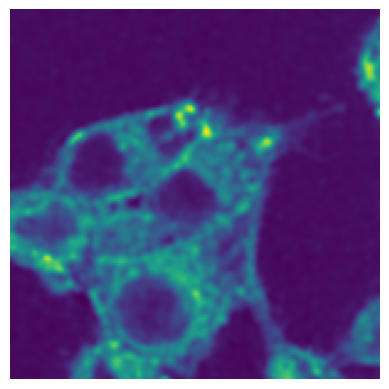

In [38]:
tik_img2 = tikhonov(img26,psf,lam=0.5)
plt.imshow(tik_img2[50:200,50:200])
plt.axis('off')
plt.show()

BM3D

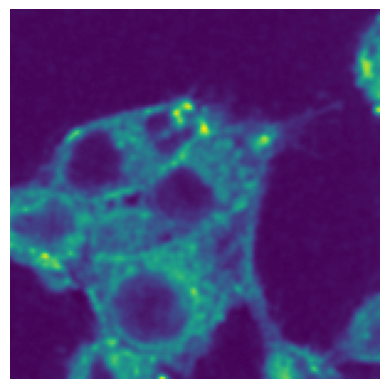

In [39]:
bm3d_img2 = bm3d.bm3d(img26,sigma_psd=0.01, stage_arg=bm3d.BM3DStages.ALL_STAGES)
plt.imshow(bm3d_img2[50:200,50:200])
plt.axis('off')
plt.show()